In [4]:
%load_ext autoreload
%autoreload 2

import healpy as hp
import numpy as np
from astropy.io import fits

# import unwiseact as ua
import matplotlib.pyplot as plt
# Load the data
# table = ua.read_results('cibdBeta')
# print(table.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import unwiseact_healpix
DATA_DIR = unwiseact_healpix.OUTPATH

# table = unwiseact_healpix.read_results_jit("midz_cibdBeta_1.0_T_10.7_results.txt")

# table.keys()
# ells = table['ell']
# cl_gy = table['cl_gy']

# plt.plot(ells, cl_gy)
# plt.xscale('log')
# plt.xlim(50, 1000)


## testing of the Blue $\times$ SZ

Using sample galaxy sample blue. the custom code used here is `galaxy_map_read.py`.

Using the deprojection sampke deproject cib dbeta beta=1.6, T = 10.7
`deprojection index.py`.




In [3]:
from assets import galaxy_map_read as gmr

unwise_sample = 'blue'
unwise_map = gmr.makemap_healpix(unwise_sample)

mask = gmr.readmask(unwise_sample)

Galaxy sample generating started for blue
Galaxy sample generating finished for blue           
Galaxy mask ready for blue           


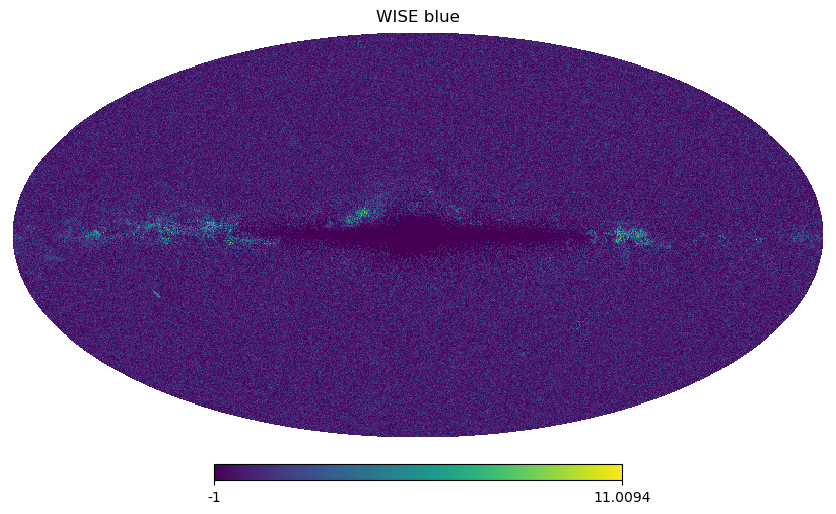

In [5]:
hp.mollview(unwise_map, title='WISE '+unwise_sample)

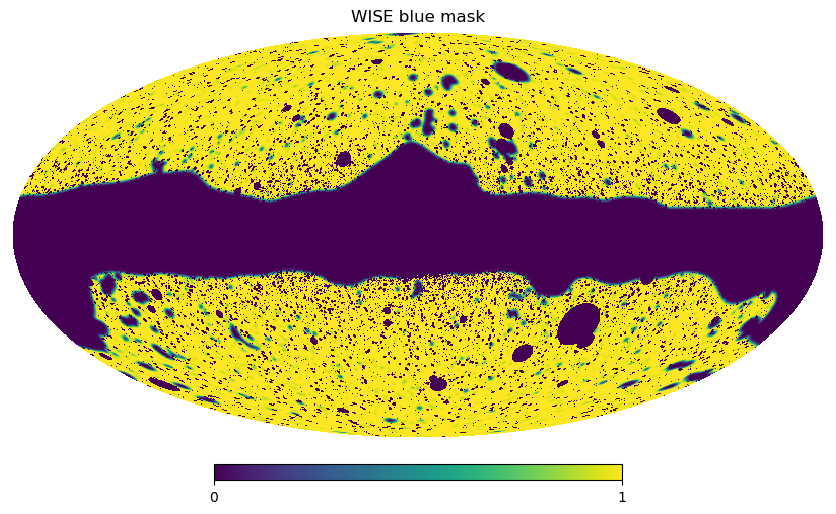

In [6]:
hp.mollview(mask, title='WISE '+unwise_sample+' mask')

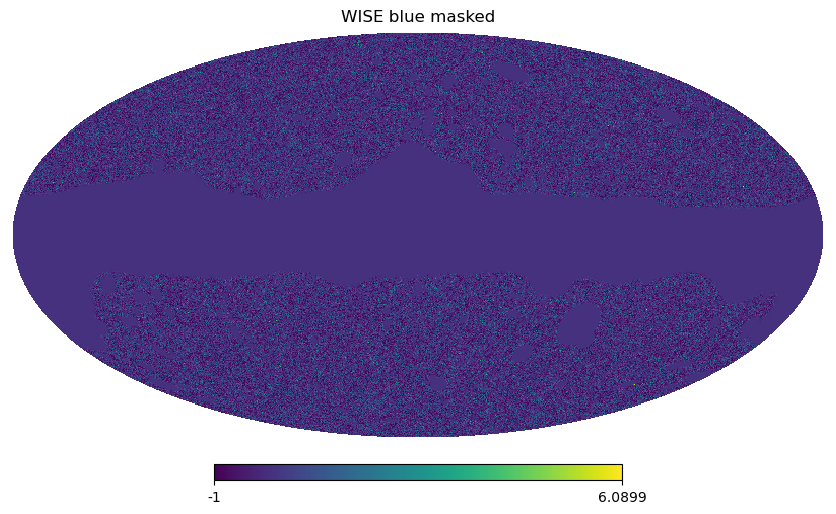

In [7]:
hp.mollview(unwise_map*mask, title='WISE '+unwise_sample+' masked')

Reading mask...


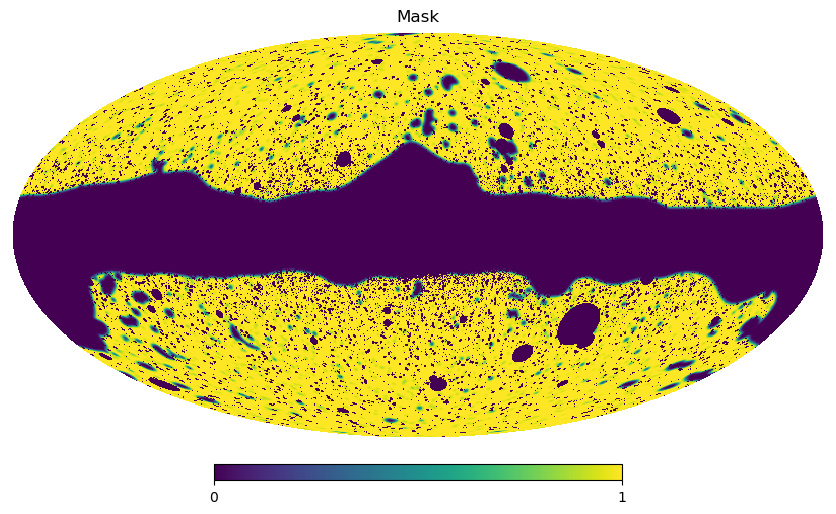

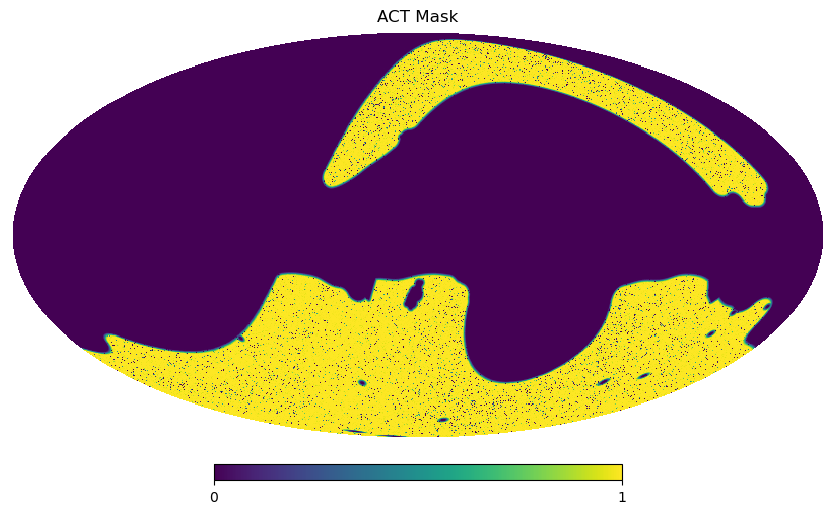

In [8]:
from assets import make_galaxy_map as mgm
from assets import deprojection_index as di

mask = mgm.readmask()
hp.mollview(mask, title='Mask')

mask_act = di.read_composite_mask()
hp.mollview(mask_act, title='ACT Mask')

In [11]:
act_map_codex = di.get_ymap_index_act_selected('cibdBeta',nu_range = [1.55,1.6],T_range = [10.7,10.8])
# for index in act_map_codex:
index = act_map_codex[0]
print(index)
map = index.generate_map()

map object with cibdBeta 1.6 10.7


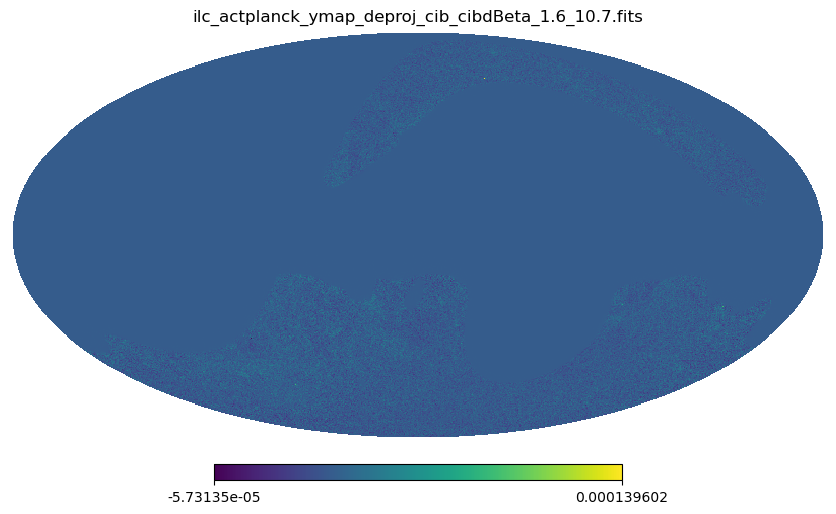

In [13]:
hp.mollview(map, title=index.filename)

In [38]:
total_mask = mask*mask_act
f_sky = np.mean(total_mask)
print('fsky=',f_sky)

fsky= 0.2635115


In [15]:
res_anafast = hp.anafast(map1 = map*mask_act, map2 = unwise_map*mask, lmax = 4000)

In [28]:
res_anafast_rescaled = res_anafast/f_sky
nell = len(res_anafast_rescaled)
binned_averaged = res_anafast_rescaled[:nell//50*50].reshape(-1,50).mean(axis=1)
ells = np.arange(nell//50)*50
anafact_result = {'ell':ells,'cl_gy':binned_averaged}

## The healpix namaster approach read result

The code was in `unwiseact_healpix.py`.

In [26]:
OUTPATH = '/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/healpix/'

def read_results(path:str):
    # ignore the '#' in the header
    
    data = np.loadtxt(path,skiprows=1)
    header = open(path).readline().strip().split()
    header.remove('#')
    table = {header[i]:data[:,i] for i in range(len(header))}
    return table

In [64]:
table_midz = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/healpix_midz_blueloss/midz_cibdBeta_1.7_T_10.7_results.txt')
print(table_midz.keys())

table_midz_gg = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/midz_gg/midz_auto_results.txt')
print(table_midz_gg.keys())

table_lowz_gg = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/lowz_gg/lowz_auto_results.txt')
print(table_lowz_gg.keys())

table_lowz = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/healpix_midz_blueloss/lowz_cibdBeta_1.7_T_10.7_results.txt')    
print(table_lowz.keys())

table_blue = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/healpix_midz_blueloss/blue_cibdBeta_1.6_T_10.7_results.txt')
print(table_blue.keys())

table_blue_gg = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/blue_gg/blue_auto_results.txt')
print(table_blue_gg.keys())

act_article_result = np.genfromtxt('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/digitized_results/unwise_blue_act_dbeta_beta_1.6.csv',delimiter=',')

ell_act_article,cl_gy_act_article = act_article_result[:,0],act_article_result[:,1]

dict_keys(['ell', 'cl_gy', 'cl_yy'])
dict_keys(['ell', 'cl_auto'])
dict_keys(['ell', 'cl_auto'])
dict_keys(['ell', 'cl_gy', 'cl_yy'])
dict_keys(['ell', 'cl_gy', 'cl_yy'])
dict_keys(['ell', 'cl_auto'])


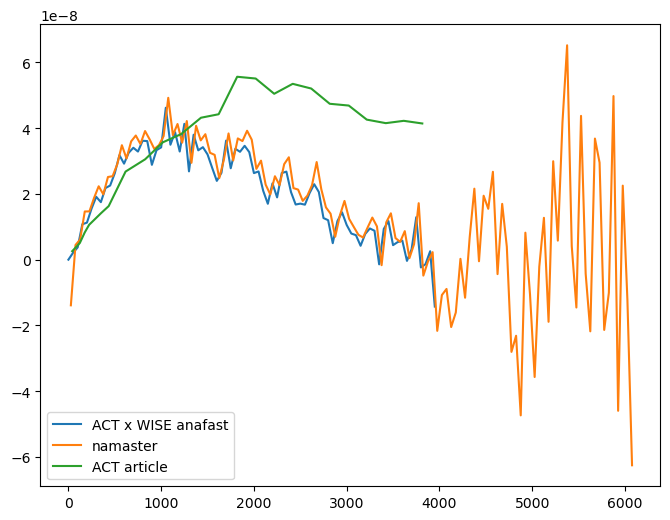

In [65]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(anafact_result['ell'],anafact_result['cl_gy']*anafact_result['ell']*(anafact_result['ell']+1)/2/np.pi,label='ACT x WISE anafast')
ax.plot(table_blue['ell'],table_blue['cl_gy']*table_blue['ell']*(table_blue['ell']+1)/2/np.pi,label='namaster')
ax.plot(ell_act_article,cl_gy_act_article,label='ACT article')

ax.legend()



(20000, 2)


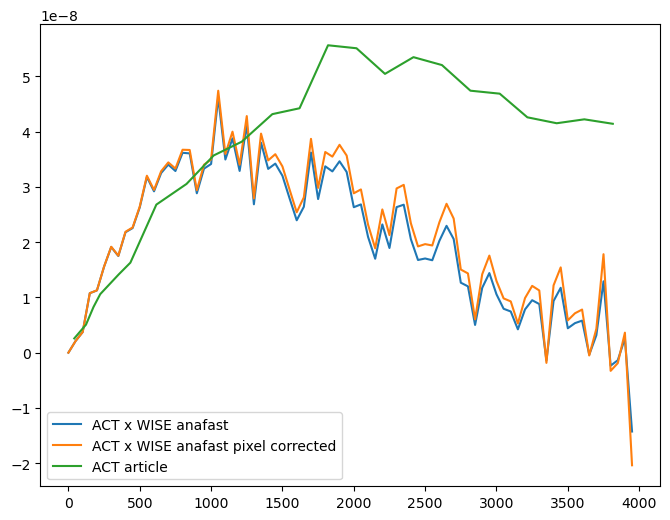

In [70]:
beam = np.loadtxt('/mnt/d/data_large/unwise_sz/ACT/act_beam/effective_beam.txt')
print(beam.shape)

pixel_correction = hp.pixwin(nside=2048)**2

anafast_result_beamcorrected = res_anafast_rescaled/beam[:4001,1]
anafast_result_beam_corrected_binned = anafast_result_beamcorrected[:nell//50*50].reshape(-1,50).mean(axis=1)

anafast_result_pixelcorrected = res_anafast_rescaled/pixel_correction[:4001]
anafast_result_pixel_corrected_binned = anafast_result_pixelcorrected[:nell//50*50].reshape(-1,50).mean(axis=1)

fig,ax = plt.subplots(1,1,figsize=(8,6))
# ax.plot(anafact_result['ell'],anafact_result['cl_gy']*anafact_result['ell']*(anafact_result['ell']+1)/2/np.pi,label='ACT x WISE anafast')

ells_anafast = np.arange(4001//50) * 50
# ax.plot(ells_anafast,anafast_result_beam_corrected_binned*ells_anafast*(ells_anafast+1)/2/np.pi,label='ACT x WISE anafast beam corrected')

ax.plot(anafact_result['ell'],anafact_result['cl_gy']*anafact_result['ell']*(anafact_result['ell']+1)/2/np.pi,label='ACT x WISE anafast')

ax.plot(ells_anafast,anafast_result_pixel_corrected_binned*ells_anafast*(ells_anafast+1)/2/np.pi,label='ACT x WISE anafast pixel corrected')

# ax.plot(table_blue['ell'],table_blue['cl_gy']*table_blue['ell']*(table_blue['ell']+1)/2/np.pi,label='namaster')
ax.plot(ell_act_article,cl_gy_act_article,label='ACT article')
ax.legend()

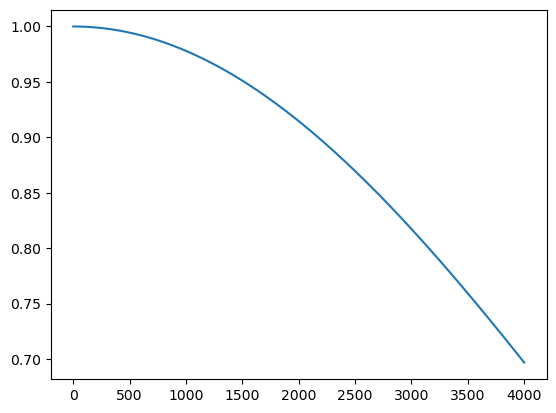

In [71]:
plt.plot(pixel_correction[:4001])

## pixelization effect
even for namaster maps, we need to use

Though it is not making a huge difference.

# compare and over plot the yy and their yy.

# PLanck gy cross correlation

recommended deprojections for planck vs recommended deprojections for act and compare gy.

!label correctly.

In [40]:
binwidth = 50
# f_sky = 0.3 # example number

ells = table_midz['ell']
pll = ells*(ells+1)/(2*np.pi)
cl_gg_midz = table_midz_gg['cl_auto']
cl_gg_blue = table_blue_gg['cl_auto']
cl_gg_lowz = table_lowz_gg['cl_auto']

cl_gy_midz = table_midz['cl_gy']
cl_gy_blue = table_blue['cl_gy']
cl_gy_lowz = table_lowz['cl_gy']

cl_yy_midz = table_midz['cl_yy']
cl_yy_blue = table_blue['cl_yy']
cl_yy_lowz = table_lowz['cl_yy']


In [41]:
err_gy_midz = np.sqrt((cl_gy_midz**2+cl_gg_midz*cl_yy_midz)/(2*ells+1)/binwidth/f_sky)
err_gy_blue = np.sqrt((cl_gy_blue**2+cl_gg_blue*cl_yy_blue)/(2*ells+1)/binwidth/f_sky)
err_gy_lowz = np.sqrt((cl_gy_lowz**2+cl_gg_lowz*cl_yy_lowz)/(2*ells+1)/binwidth/f_sky)

err_yy_midz = np.sqrt(2*cl_yy_midz**2/(2*ells+1)/binwidth/f_sky)
err_yy_blue = np.sqrt(2*cl_yy_blue**2/(2*ells+1)/binwidth/f_sky)
err_yy_lowz = np.sqrt(2*cl_yy_lowz**2/(2*ells+1)/binwidth/f_sky)

err_gg_midz = np.sqrt(2*cl_gg_midz**2/(2*ells+1)/binwidth/f_sky)
err_gg_blue = np.sqrt(2*cl_gg_blue**2/(2*ells+1)/binwidth/f_sky)
err_gg_lowz = np.sqrt(2*cl_gg_lowz**2/(2*ells+1)/binwidth/f_sky)

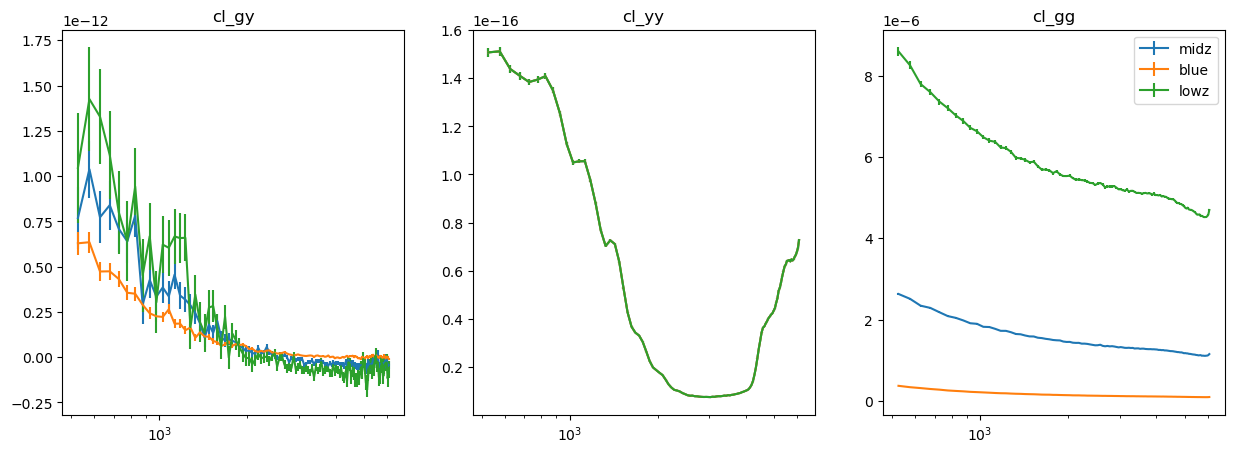

In [42]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

plot_omit = 10
# ax[0].errorbar(ells, cl_gy_midz, yerr=err_gy_midz, label='midz')
# ax[0].errorbar(ells, cl_gy_blue, yerr=err_gy_blue, label='blue')
ax[0].errorbar(ells[plot_omit:], cl_gy_midz[plot_omit:], yerr=err_gy_midz[plot_omit:], label='midz')
ax[0].errorbar(ells[plot_omit:], cl_gy_blue[plot_omit:], yerr=err_gy_blue[plot_omit:], label='blue')
ax[0].errorbar(ells[plot_omit:], cl_gy_lowz[plot_omit:], yerr=err_gy_lowz[plot_omit:], label='lowz')
ax[0].set_xscale('log')

# ax[1].errorbar(ells, cl_yy_midz, yerr=err_yy_midz, label='midz')
# ax[1].errorbar(ells, cl_yy_blue, yerr=err_yy_blue, label='blue')
ax[1].errorbar(ells[plot_omit:], cl_yy_midz[plot_omit:], yerr=err_yy_midz[plot_omit:], label='midz')
ax[1].errorbar(ells[plot_omit:], cl_yy_blue[plot_omit:], yerr=err_yy_blue[plot_omit:], label='blue')
ax[1].errorbar(ells[plot_omit:], cl_yy_lowz[plot_omit:], yerr=err_yy_lowz[plot_omit:], label='lowz')
ax[1].set_xscale('log')

# ax[2].errorbar(ells, cl_gg_midz, yerr=err_gg_midz, label='midz')
# ax[2].errorbar(ells, cl_gg_blue, yerr=err_gg_blue, label='blue')
ax[2].errorbar(ells[plot_omit:], cl_gg_midz[plot_omit:], yerr=err_gg_midz[plot_omit:], label='midz')
ax[2].errorbar(ells[plot_omit:], cl_gg_blue[plot_omit:], yerr=err_gg_blue[plot_omit:], label='blue')
ax[2].errorbar(ells[plot_omit:], cl_gg_lowz[plot_omit:], yerr=err_gg_lowz[plot_omit:], label='lowz')
ax[2].set_xscale('log')

ax[0].set_title('cl_gy')
ax[1].set_title('cl_yy')
ax[2].set_title('cl_gg')

plt.legend()

# PLot contrast between blue

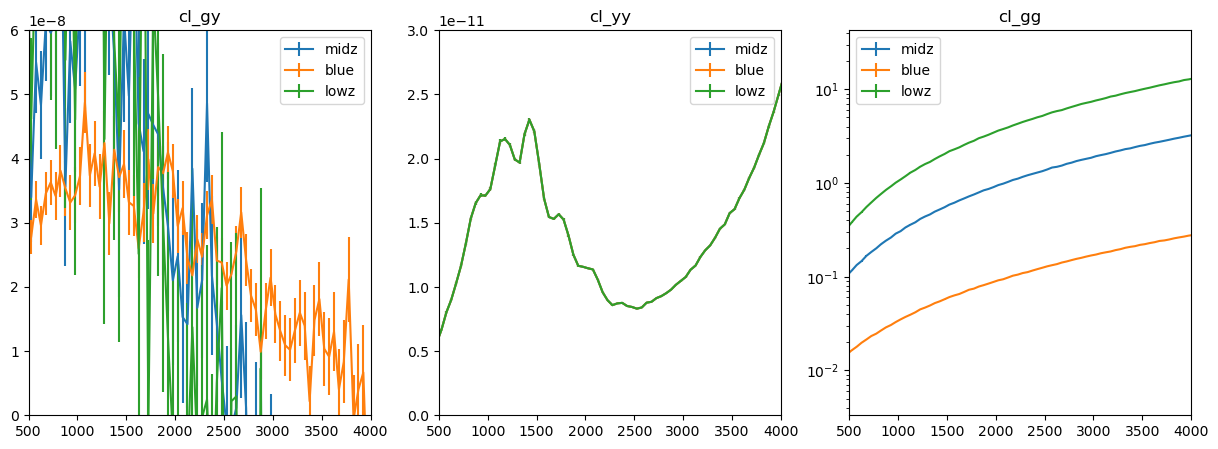

In [88]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

plot_omit = 2
# ax[0].errorbar(ells, cl_gy_midz, yerr=err_gy_midz, label='midz')
# ax[0].errorbar(ells, cl_gy_blue, yerr=err_gy_blue, label='blue')
ax[0].errorbar(ells[plot_omit:], cl_gy_midz[plot_omit:]*pll[plot_omit:], yerr=err_gy_midz[plot_omit:]*pll[plot_omit:], label='midz')
ax[0].errorbar(ells[plot_omit:], cl_gy_blue[plot_omit:]*pll[plot_omit:], yerr=err_gy_blue[plot_omit:]*pll[plot_omit:], label='blue')
ax[0].errorbar(ells[plot_omit:], cl_gy_lowz[plot_omit:]*pll[plot_omit:], yerr=err_gy_lowz[plot_omit:]*pll[plot_omit:], label='lowz')
# ax[0].set_xscale('log')

# ax[1].errorbar(ells, cl_yy_midz, yerr=err_yy_midz, label='midz')
# ax[1].errorbar(ells, cl_yy_blue, yerr=err_yy_blue, label='blue')
ax[1].errorbar(ells[plot_omit:], cl_yy_midz[plot_omit:]*pll[plot_omit:], yerr=err_yy_midz[plot_omit:]*pll[plot_omit:], label='midz')
ax[1].errorbar(ells[plot_omit:], cl_yy_blue[plot_omit:]*pll[plot_omit:], yerr=err_yy_blue[plot_omit:]*pll[plot_omit:], label='blue')
ax[1].errorbar(ells[plot_omit:], cl_yy_lowz[plot_omit:]*pll[plot_omit:], yerr=err_yy_lowz[plot_omit:]*pll[plot_omit:], label='lowz')
# ax[1].set_xscale('log')

# ax[2].errorbar(ells, cl_gg_midz, yerr=err_gg_midz, label='midz')
# ax[2].errorbar(ells, cl_gg_blue, yerr=err_gg_blue, label='blue')
ax[2].errorbar(ells[plot_omit:], cl_gg_midz[plot_omit:]*pll[plot_omit:], yerr=err_gg_midz[plot_omit:]*pll[plot_omit:], label='midz')
ax[2].errorbar(ells[plot_omit:], cl_gg_blue[plot_omit:]*pll[plot_omit:], yerr=err_gg_blue[plot_omit:]*pll[plot_omit:], label='blue')
ax[2].errorbar(ells[plot_omit:], cl_gg_lowz[plot_omit:]*pll[plot_omit:], yerr=err_gg_lowz[plot_omit:]*pll[plot_omit:], label='lowz')
# ax[2].set_xscale('log')

ax[0].set_title('cl_gy')
ax[1].set_title('cl_yy')
ax[2].set_title('cl_gg')

ax[0].set_xlim(500, 4000)
ax[0].set_ylim(0e-7,6e-8)
ax[1].set_xlim(500, 4000)
ax[1].set_ylim(0,3e-11)
ax[2].set_xlim(500, 4000)
# ax[2].set_ylim(0,20)
ax[2].set_yscale('log')

ax[0].legend()
ax[1].legend()
ax[2].legend()

## The original WISE correlation (REPRODUCE THIS)

![Original ACT y-unwise correlation](image.png)

In [16]:
print(cl_gg[:10])

[ 1.13186130e-02 -1.69319711e-04 -2.04897973e-05 -1.23885976e-05
 -7.76040149e-06 -4.31966095e-06 -2.05211273e-06 -8.35547070e-07
 -3.69901324e-07 -3.45941066e-07]


ValueError: could not convert string to float: 'gy'

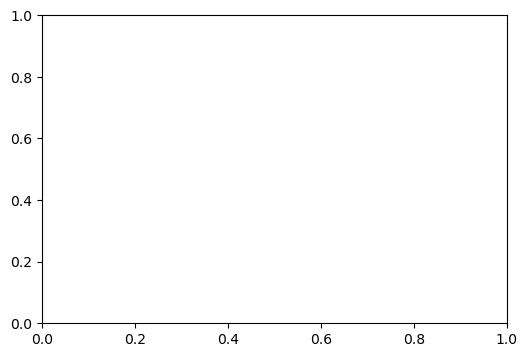

In [7]:
table_blue = read_results('/mnt/c/Users/gdzhao/projects/unwise_sz/unwiseact_results/healpix/cibdBeta_results_first_sample.txt')
cl_gy_blue = table_blue['cibdBeta_1.0_T_10.7_gy']
ell = table_blue['ell']
pll = ell*(ell+1)/(2*np.pi) # Power spectrum normalization

# def infer_params_from_string(s):
#     parts = s.split('_')
#     beta = float(parts[1])
#     T = float(parts[3])
#     return beta, T

plot_left = 5
plot_right = 1
fig,ax = plt.subplots(1,1, figsize=(6,4))



# for models in table.keys():
#     # if models == 'ell':
#     #     continue
#     # if '_yy' in models:
#     #     continue   
#     # beta, T = infer_params_from_string(models)
#     # print('beta =', beta, 'T =', T)
#     data = table[models]
#     # hp.write_cl('cibdBeta_cl_beta{:.2f}_T{:.2f}.fits'.format(beta, T), data/pll)
#     ax.plot(ell[plot_left:-plot_right], (data*pll)[plot_left:-plot_right], label='beta={:.2f} T={:.2f}'.format(beta, T))
ax.

# ax.plot(ell[plot_left:-plot_right], pll[plot_left:-plot_right]*np.mean(data), label='l(l+1)')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell^{gy}/(2\pi)$')
ax.legend()
plt.show()

beta = 1.0 T = 10.7
beta = 1.2 T = 10.7


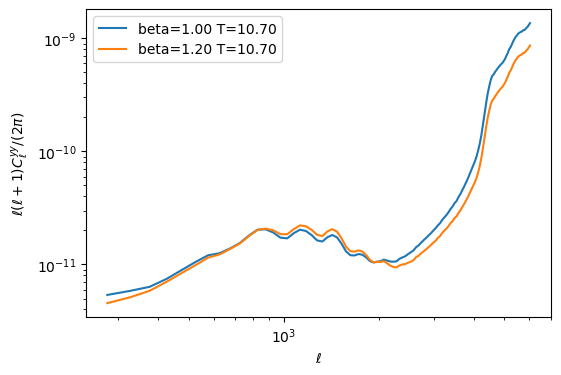

In [5]:
ell = table['ell']
pll = ell*(ell+1)/(2*np.pi) # Power spectrum normalization

def infer_params_from_string(s):
    parts = s.split('_')
    beta = float(parts[1])
    T = float(parts[3])
    return beta, T

plot_left = 5
plot_right = 1
fig,ax = plt.subplots(1,1, figsize=(6,4))
for models in table.keys():
    if models == 'ell':
        continue
    if '_gy' in models:
        continue   
    beta, T = infer_params_from_string(models)
    print('beta =', beta, 'T =', T)
    data = table[models]
    # hp.write_cl('cibdBeta_cl_beta{:.2f}_T{:.2f}.fits'.format(beta, T), data/pll)
    ax.plot(ell[plot_left:-plot_right], (data*pll)[plot_left:-plot_right], label='beta={:.2f} T={:.2f}'.format(beta, T))

# ax.plot(ell[plot_left:-plot_right], pll[plot_left:-plot_right]*np.mean(data), label='l(l+1)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell^{yy}/(2\pi)$')
ax.legend()
plt.show()

beta = 1.0 T = 10.7
beta = 1.2 T = 10.7


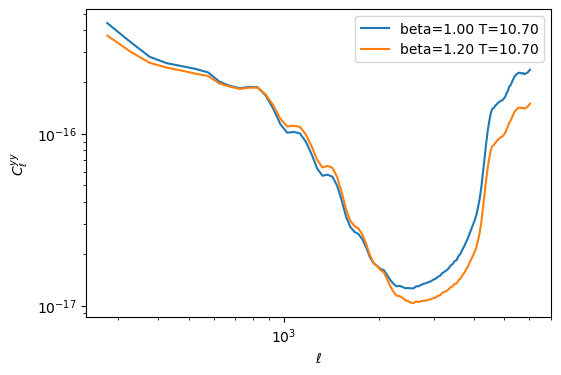

In [8]:
ell = table['ell']
pll = ell*(ell+1)/(2*np.pi) # Power spectrum normalization

def infer_params_from_string(s):
    parts = s.split('_')
    beta = float(parts[1])
    T = float(parts[3])
    return beta, T

plot_left = 5
plot_right = 1
fig,ax = plt.subplots(1,1, figsize=(6,4))
for models in table.keys():
    if models == 'ell':
        continue
    if '_gy' in models:
        continue   
    beta, T = infer_params_from_string(models)
    print('beta =', beta, 'T =', T)
    data = table[models]
    # hp.write_cl('cibdBeta_cl_beta{:.2f}_T{:.2f}.fits'.format(beta, T), data/pll)
    ax.plot(ell[plot_left:-plot_right], (data)[plot_left:-plot_right], label='beta={:.2f} T={:.2f}'.format(beta, T))

# ax.plot(ell[plot_left:-plot_right], pll[plot_left:-plot_right]*2e-16, label='l(l+1)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell^{yy}$')
ax.legend()
plt.show()

# CL_yy analysis

```NSIDE=2048```, lmax = 2*NSIDE+1 = 4097

The rerising of $C_l^{yy}$ is at around l = 3k is probably because over lmax capacity

beta = 1.0 T = 10.7
beta = 1.2 T = 10.7


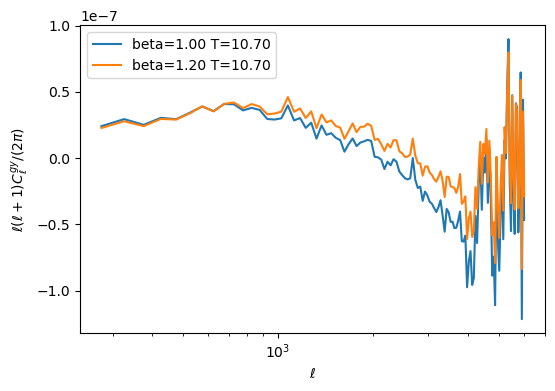

In [9]:
ell = table['ell']
pll = ell*(ell+1)/(2*np.pi) # Power spectrum normalization

def infer_params_from_string(s):
    parts = s.split('_')
    beta = float(parts[1])
    T = float(parts[3])
    return beta, T

plot_left = 5
plot_right = 1
fig,ax = plt.subplots(1,1, figsize=(6,4))
for models in table.keys():
    if models == 'ell':
        continue
    if '_yy' in models:
        continue   
    beta, T = infer_params_from_string(models)
    print('beta =', beta, 'T =', T)
    data = table[models]
    # hp.write_cl('cibdBeta_cl_beta{:.2f}_T{:.2f}.fits'.format(beta, T), data/pll)
    ax.plot(ell[plot_left:-plot_right], (data*pll)[plot_left:-plot_right], label='beta={:.2f} T={:.2f}'.format(beta, T))

# ax.plot(ell[plot_left:-plot_right], pll[plot_left:-plot_right]*np.mean(data), label='l(l+1)')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell^{gy}/(2\pi)$')
ax.legend()
plt.show()

beta = 1.0 T = 10.7
beta = 1.2 T = 10.7


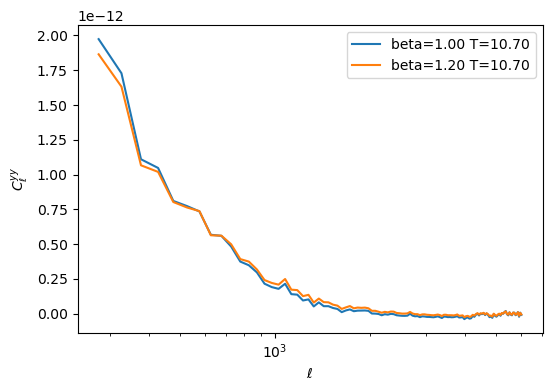

In [10]:
ell = table['ell']
pll = ell*(ell+1)/(2*np.pi) # Power spectrum normalization

def infer_params_from_string(s):
    parts = s.split('_')
    beta = float(parts[1])
    T = float(parts[3])
    return beta, T

plot_left = 5
plot_right = 1
fig,ax = plt.subplots(1,1, figsize=(6,4))
for models in table.keys():
    if models == 'ell':
        continue
    if '_yy' in models:
        continue   
    beta, T = infer_params_from_string(models)
    print('beta =', beta, 'T =', T)
    data = table[models]
    # hp.write_cl('cibdBeta_cl_beta{:.2f}_T{:.2f}.fits'.format(beta, T), data/pll)
    ax.plot(ell[plot_left:-plot_right], (data)[plot_left:-plot_right], label='beta={:.2f} T={:.2f}'.format(beta, T))

# ax.plot(ell[plot_left:-plot_right], pll[plot_left:-plot_right]*2e-16, label='l(l+1)')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell^{yy}$')
ax.legend()
plt.show()

## Cl_gy analysis

Update
The clgy is start to see some results. But whether this is the true correlation needs to be checked. One thing I can check is to do this in car projection and use other libraries.

+++++++++++++++++++++++++++++++++++
This analysis got only static. Something is wrong. The wrong thing is about the coordinate system of act sample.

By default the sample is in ra,dec, or celestial coordinates. we need to rotate to galactic coordinates.

In [44]:
from assets import deprojection_index as di
from assets import make_galaxy_map as mgm

unwise_map = mgm.makemap()
unwise_mask = mgm.read_compositemask()

Reading weights...
Reading mask...
Making galaxy map 1
Reading mask...


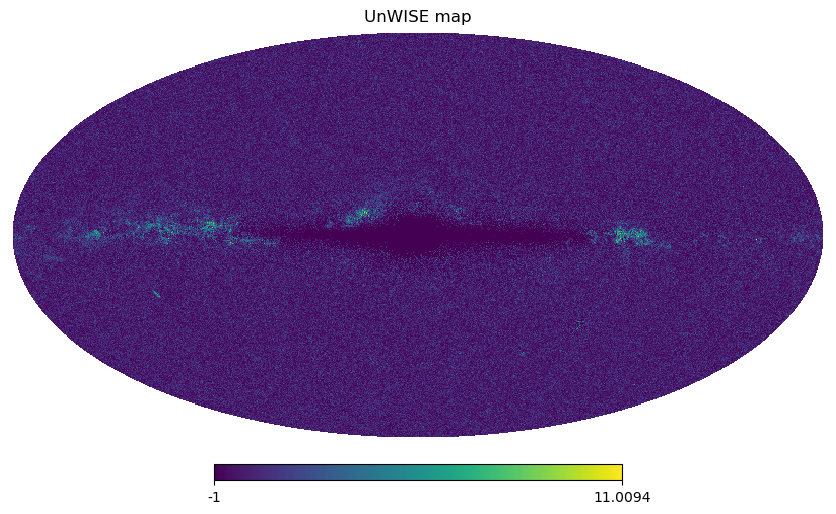

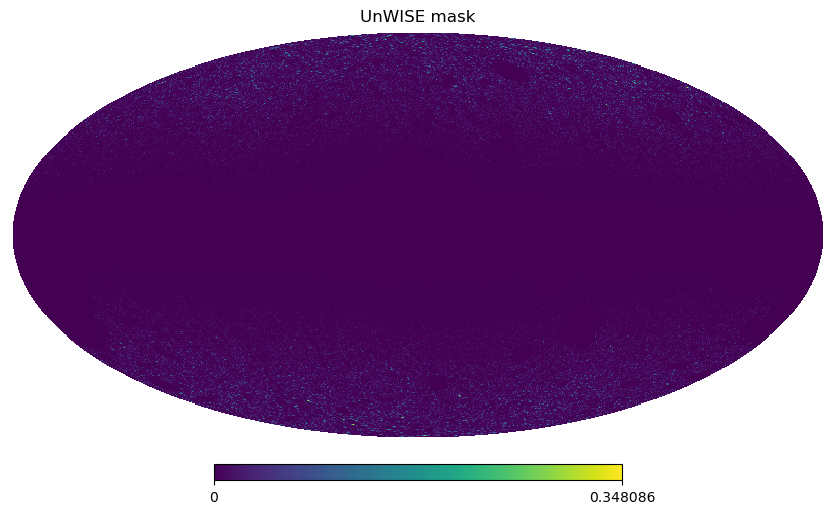

In [45]:
hp.mollview(unwise_map, title='UnWISE map')
hp.mollview(unwise_mask, title='UnWISE mask')

In [ ]:
PATHMAP = mgm.PATHMAP

print('Reading mask...')
mask = hp.read_map(PATHMAP+'mask/mask_unWISE_full_v10.fits')
lost = fits.open(PATHMAP+"loss/unmaskedareafrac-flag.fits")
mask_lost = lost[0].data
valid = (mask_lost !=0 ).astype(np.float64)

galmask = mask * valid

Reading mask...


In [49]:
valid_grade = hp.ud_grade(valid, nside_out=128)

In [51]:
print(np.sum(1.0-valid))

8.0


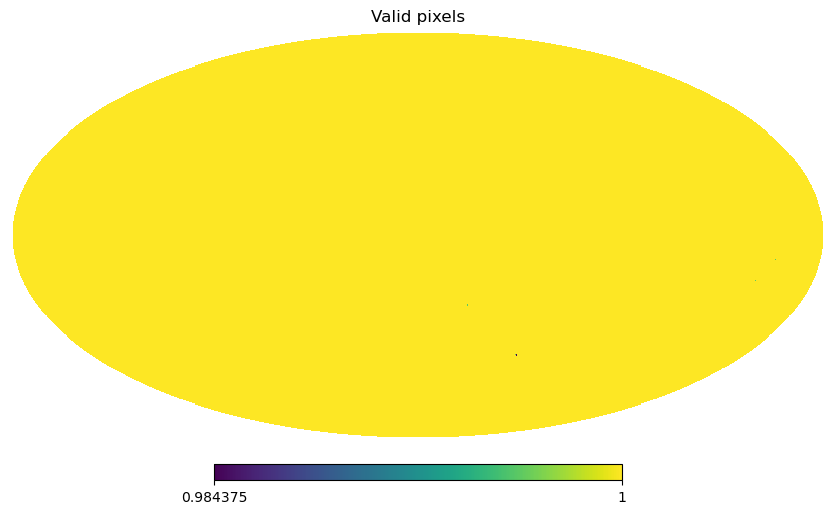

In [50]:
hp.mollview(valid_grade, title='Valid pixels')

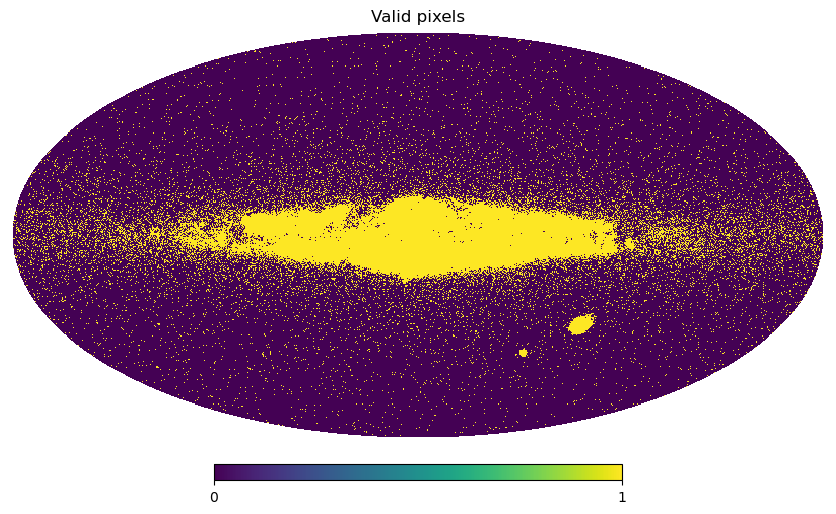

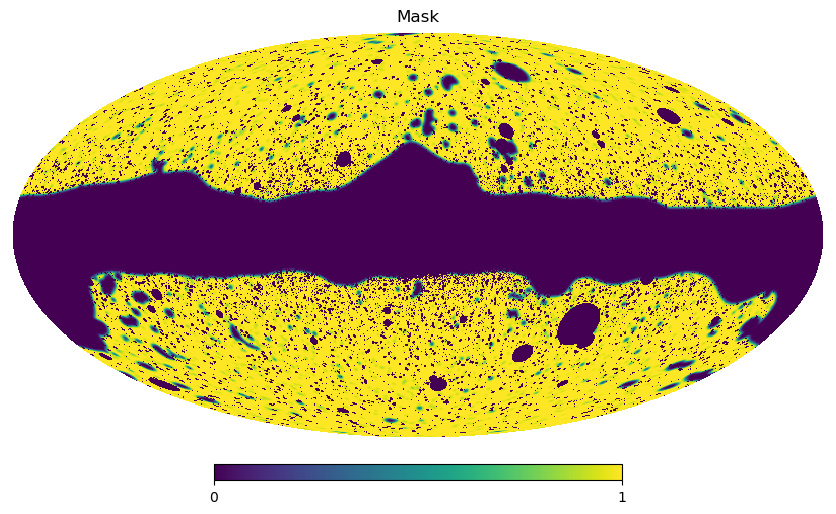

In [55]:
hp.mollview(valid, title='Valid pixels')
hp.mollview(mask, title='Mask')

In [56]:
act_codex = di.get_ymap_index_act()
for index in act_codex:
    print(index)

map object with cib 1.0 10.7
map object with cib 1.0 24.0
map object with cib 1.2 10.7
map object with cib 1.2 24.0
map object with cib 1.4 10.7
map object with cib 1.4 24.0
map object with cib 1.6 10.7
map object with cib 1.6 24.0
map object with cib 1.7 10.7
map object with cib 1.7 24.0
map object with cib 1.8 10.7
map object with cib 1.8 24.0
map object with cib 2.0 10.7
map object with cib 2.0 24.0
map object with cibdBeta 1.0 10.7
map object with cibdBeta 1.0 24.0
map object with cibdBeta 1.15 24.0
map object with cibdBeta 1.2 10.7
map object with cibdBeta 1.2 24.0
map object with cibdBeta 1.3 24.0
map object with cibdBeta 1.35 24.0
map object with cibdBeta 1.45 24.0
map object with cibdBeta 1.4 10.7
map object with cibdBeta 1.4 24.0
map object with cibdBeta 1.6 10.7
map object with cibdBeta 1.6 24.0
map object with cibdBeta 1.7 10.7
map object with cibdBeta 1.7 24.0
map object with cibdBeta 1.8 10.7
map object with cibdBeta 1.8 24.0
map object with cibdBeta 2.0 10.7
map object wi

In [ ]:
index = act_codex[0]
flat_act= index.read()

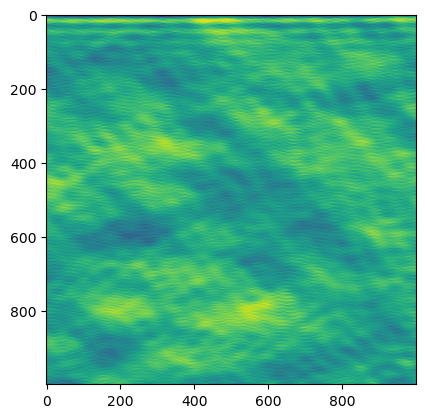

In [69]:
plt.imshow(flat_act[0][:1000,:1000])

In [70]:
healpix_map = index.generate_map(nside = 512)

Generating HEALPix map...


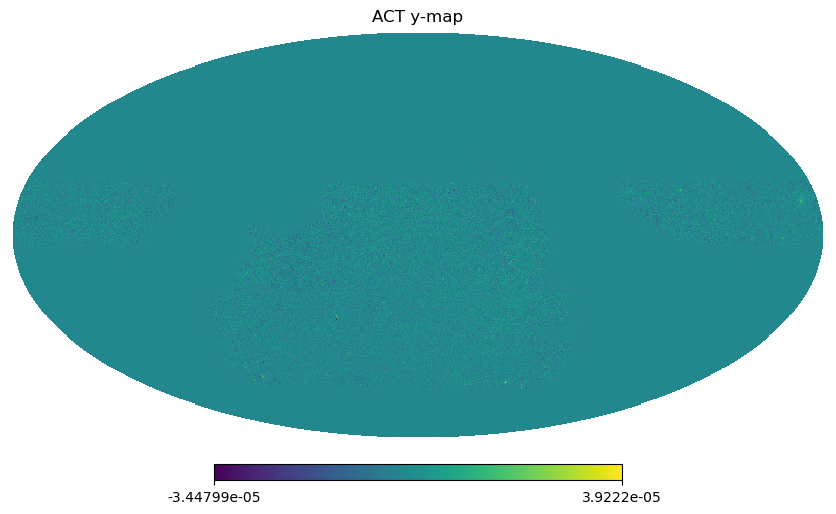

In [71]:
hp.mollview(healpix_map, title='ACT y-map')

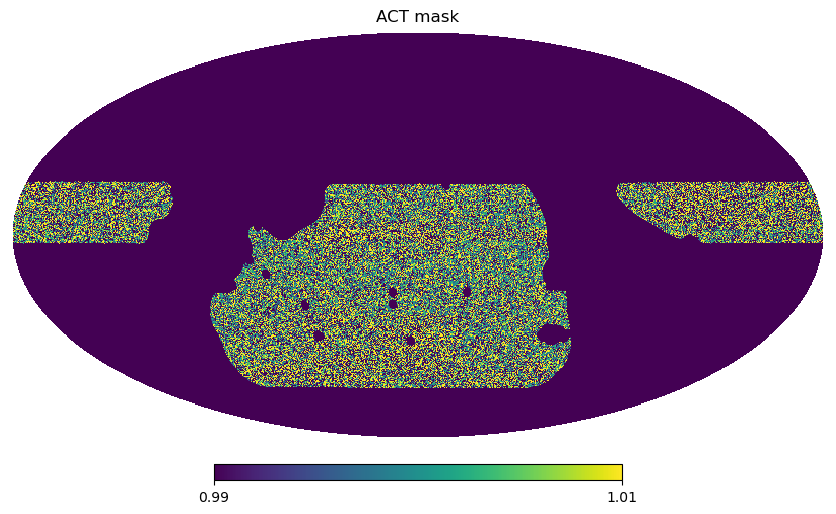

In [75]:
act_mask = di.read_composite_mask(apodize=False)
hp.mollview(act_mask, title='ACT mask', min=0.99, max=1.01)

In [77]:
## projection coords wromng

In [76]:
mask_over = (act_mask>1.0)
print(np.sum(mask_over))

7419775
